In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import KNNImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from ipynb.fs.full.data_preprocessing_function import preprocessing_data

In [23]:
#reading data
list_Xtrain=[]
list_Xtest=[]
list_ytrain=[]
list_ytest=[]

overview = pd.read_excel('../osfstorage-archive/pmdata/participant-overview.xlsx')
overview = overview.set_axis(overview.iloc[0,:],axis='columns').set_index('Participant ID',drop=True)

for x in range(1, 17):
    person_number = x
    
    person_number = str('%02d' % person_number)

    calories = []
    distance = []
    l_act = []
    m_act = []
    r_heart = []
    sedentary = []
    sleep_score = []
    sleep = []
    hr_zone = []
    v_act = []
    wellness = []
    
    display('P'+person_number)
    
    try:

        calories = pd.read_json('../osfstorage-archive/pmdata/p'+person_number+'/fitbit/calories.json')
        distance = pd.read_json('../osfstorage-archive/pmdata/p'+person_number+'/fitbit/distance.json')
        l_act = pd.read_json('../osfstorage-archive/pmdata/p'+person_number+'/fitbit/lightly_active_minutes.json')
        m_act = pd.read_json('../osfstorage-archive/pmdata/p'+person_number+'/fitbit/moderately_active_minutes.json')
        r_heart = pd.read_json('../osfstorage-archive/pmdata/p'+person_number+'/fitbit/resting_heart_rate.json')
        sedentary = pd.read_json('../osfstorage-archive/pmdata/p'+person_number+'/fitbit/sedentary_minutes.json')
        sleep_score = pd.read_csv('../osfstorage-archive/pmdata/p'+person_number+'/fitbit/sleep_score.csv')
        sleep = pd.read_json('../osfstorage-archive/pmdata/p'+person_number+'/fitbit/sleep.json')
        steps = pd.read_json('../osfstorage-archive/pmdata/p'+person_number+'/fitbit/steps.json')
        hr_zone = pd.read_json('../osfstorage-archive/pmdata/p'+person_number+'/fitbit/time_in_heart_rate_zones.json')
        v_act = pd.read_json('../osfstorage-archive/pmdata/p'+person_number+'/fitbit/very_active_minutes.json')
        wellness = pd.read_csv('../osfstorage-archive/pmdata/p'+person_number+'/pmsys/wellness.csv')  


        if x in [8,14]:
            preprocessing_result = preprocessing_data(person_number, calories, distance, l_act, m_act, r_heart, sedentary, sleep_score, sleep, steps, hr_zone, v_act, wellness)
            display('P'+person_number+' extra columns dropped')
        else:
            preprocessing_result = preprocessing_data(person_number, calories, distance, l_act, m_act, r_heart, sedentary, sleep_score, sleep, steps, hr_zone, v_act, wellness)

        #handling missing values on target
        preprocessing_result['readiness'] = preprocessing_result['readiness'].shift(periods=-1) #shift next date's readiness to current date
        preprocessing_result = preprocessing_result[preprocessing_result['readiness'].notna()] #drop missing values on readiness

        #zero values with core attributes to nan
        preprocessing_result['calories'] = preprocessing_result['calories'].replace(0,np.nan)
        preprocessing_result['distance'] = preprocessing_result['distance'].replace(0,np.nan)
        preprocessing_result['l_act'] = preprocessing_result['l_act'].replace(0,np.nan)
        preprocessing_result['resting_heart'] = preprocessing_result['resting_heart'].replace(0,np.nan)
        preprocessing_result['steps'] = preprocessing_result['steps'].replace(0,np.nan)
                     
        #missing values filled with mean value of the column
        #not specified attribute's missing value will be calculated by knn imputation
        preprocessing_result.loc[:,'distance'] = preprocessing_result.loc[:,'distance'].fillna(preprocessing_result.loc[:,'distance'].mean())
        preprocessing_result.loc[:,'l_act'] = preprocessing_result.loc[:,'l_act'].fillna(preprocessing_result.loc[:,'l_act'].mean())
        preprocessing_result.loc[:,'sedentary'] = preprocessing_result.loc[:,'sedentary'].fillna(preprocessing_result.loc[:,'sedentary'].mean())
        preprocessing_result.loc[:,'sleep_composition_score'] = preprocessing_result.loc[:,'sleep_composition_score'].fillna(preprocessing_result.loc[:,'sleep_composition_score'].mean())
        preprocessing_result.loc[:,'sleep_revitalization_score'] = preprocessing_result.loc[:,'sleep_revitalization_score'].fillna(preprocessing_result.loc[:,'sleep_revitalization_score'].mean())
        preprocessing_result.loc[:,'sleep_duration_score'] = preprocessing_result.loc[:,'sleep_duration_score'].fillna(preprocessing_result.loc[:,'sleep_duration_score'].mean())
        preprocessing_result.loc[:,'deep_sleep_in_minutes'] = preprocessing_result.loc[:,'deep_sleep_in_minutes'].fillna(preprocessing_result.loc[:,'deep_sleep_in_minutes'].mean())
        preprocessing_result.loc[:,'sleep_resting_heart_rate'] = preprocessing_result.loc[:,'sleep_resting_heart_rate'].fillna(preprocessing_result.loc[:,'sleep_resting_heart_rate'].mean())
        preprocessing_result.loc[:,'sleep_restlessness'] = preprocessing_result.loc[:,'sleep_restlessness'].fillna(preprocessing_result.loc[:,'sleep_restlessness'].mean())
        preprocessing_result.loc[:,'sleep_duration'] = preprocessing_result.loc[:,'sleep_duration'].fillna(preprocessing_result.loc[:,'sleep_duration'].mean())
        preprocessing_result.loc[:,'sleep_minutesAsleep'] = preprocessing_result.loc[:,'sleep_minutesAsleep'].fillna(preprocessing_result.loc[:,'sleep_minutesAsleep'].mean())
        preprocessing_result.loc[:,'sleep_minutesAwake'] = preprocessing_result.loc[:,'sleep_minutesAwake'].fillna(preprocessing_result.loc[:,'sleep_minutesAwake'].mean())
        preprocessing_result.loc[:,'sleep_timeInBed'] = preprocessing_result.loc[:,'sleep_timeInBed'].fillna(preprocessing_result.loc[:,'sleep_timeInBed'].mean())
        preprocessing_result.loc[:,'sleep_efficiency'] = preprocessing_result.loc[:,'sleep_efficiency'].fillna(preprocessing_result.loc[:,'sleep_efficiency'].mean())
        preprocessing_result.loc[:,'hr_below_zone1'] = preprocessing_result.loc[:,'hr_below_zone1'].fillna(preprocessing_result.loc[:,'hr_below_zone1'].mean())


        #normalization to use knn imputer
        scaler = MinMaxScaler()
        preprocessing_normalized = scaler.fit_transform(preprocessing_result)
        preprocessing_normalized = pd.DataFrame(preprocessing_normalized, columns=preprocessing_result.columns)

        
        #using knn imputation to fill in remaining missing values

        imputer = KNNImputer()
        df = pd.DataFrame(imputer.fit_transform(preprocessing_normalized)).set_index(preprocessing_result.index)
        df.columns = preprocessing_normalized.columns
        preprocessing_normalized = df

        #replace target values with the values before normalization
        preprocessing_normalized['readiness'] = preprocessing_result['readiness']


        #add age, height, gender data
        preprocessing_normalized['age'] = overview.loc['p'+person_number,'Age']
        preprocessing_normalized['height'] = overview.loc['p'+person_number,'Height']
        if overview.loc['p'+person_number,'Gender'] == 'male':
            preprocessing_normalized['gender'] = 0
        else:
            preprocessing_normalized['gender'] = 1

        #add weekdays variable
        week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
        for i, x in enumerate(week):
            preprocessing_normalized[x] = (preprocessing_result.index.get_level_values(0).weekday == i).astype(int)

        #75:25 split on each participant's data
        X_train, X_test, y_train, y_test = train_test_split(preprocessing_normalized.iloc[:,1:],
                                                            preprocessing_normalized.loc[:,'readiness'],
                                                            test_size=0.25, shuffle=False)
        list_Xtrain.append(X_train)
        list_Xtest.append(X_test)
        list_ytrain.append(y_train)
        list_ytest.append(y_test)
        
        if person_number == '05':
            P05_Xtrain = pd.concat(list_Xtrain) 
            P05_Xtest = pd.concat(list_Xtest) 
            P05_ytrain = pd.concat(list_ytrain) 
            P05_ytest = pd.concat(list_ytest) 
        
    except:
        print(person_number+' exception from loading files')
        pass
        


'P01'

'P02'

'P03'

'P04'

'P05'

'P06'

'P07'

'P08'

'P08 extra columns dropped'

'P09'

'P10'

'P11'

'P12'

12 exception from loading files


'P13'

13 exception from loading files


'P14'

'P14 extra columns dropped'

'P15'

'P16'

In [15]:
#aggregate participants' data
agg_Xtrain = pd.concat(list_Xtrain) 
agg_Xtest = pd.concat(list_Xtest) 
agg_ytrain = pd.concat(list_ytrain) 
agg_ytest = pd.concat(list_ytest) 

before_norm = agg_Xtest

#normalization on age, height
scaled_X_train = scaler.fit_transform(agg_Xtrain)
agg_Xtrain = pd.DataFrame(scaled_X_train, columns=agg_Xtrain.columns)

scaled_X_test = scaler.fit_transform(agg_Xtest)
agg_Xtest = pd.DataFrame(scaled_X_test, columns=agg_Xtest.columns)


In [4]:
#oversampling with SMOTENC(Synthetic Minority Over-sampling Technique for Nominal and Continuous.)
from imblearn.over_sampling import SMOTENC

sm = SMOTENC(categorical_features=[20,29,30,31,32,33,34,35,36],k_neighbors=2)
agg_Xtrain, agg_ytrain = sm.fit_resample(agg_Xtrain, agg_ytrain)

In [5]:
[i.shape for i in [agg_Xtrain, agg_Xtest, agg_ytrain, agg_ytest]] #checking shape of df

[(3707, 37), (399, 37), (3707,), (399,)]

In [6]:
agg_Xtrain.to_csv('agg_Xtrain.csv')
agg_Xtest.to_csv('agg_Xtest.csv')
agg_ytrain.to_csv('agg_ytrain.csv')
agg_ytest.to_csv('agg_ytest.csv')

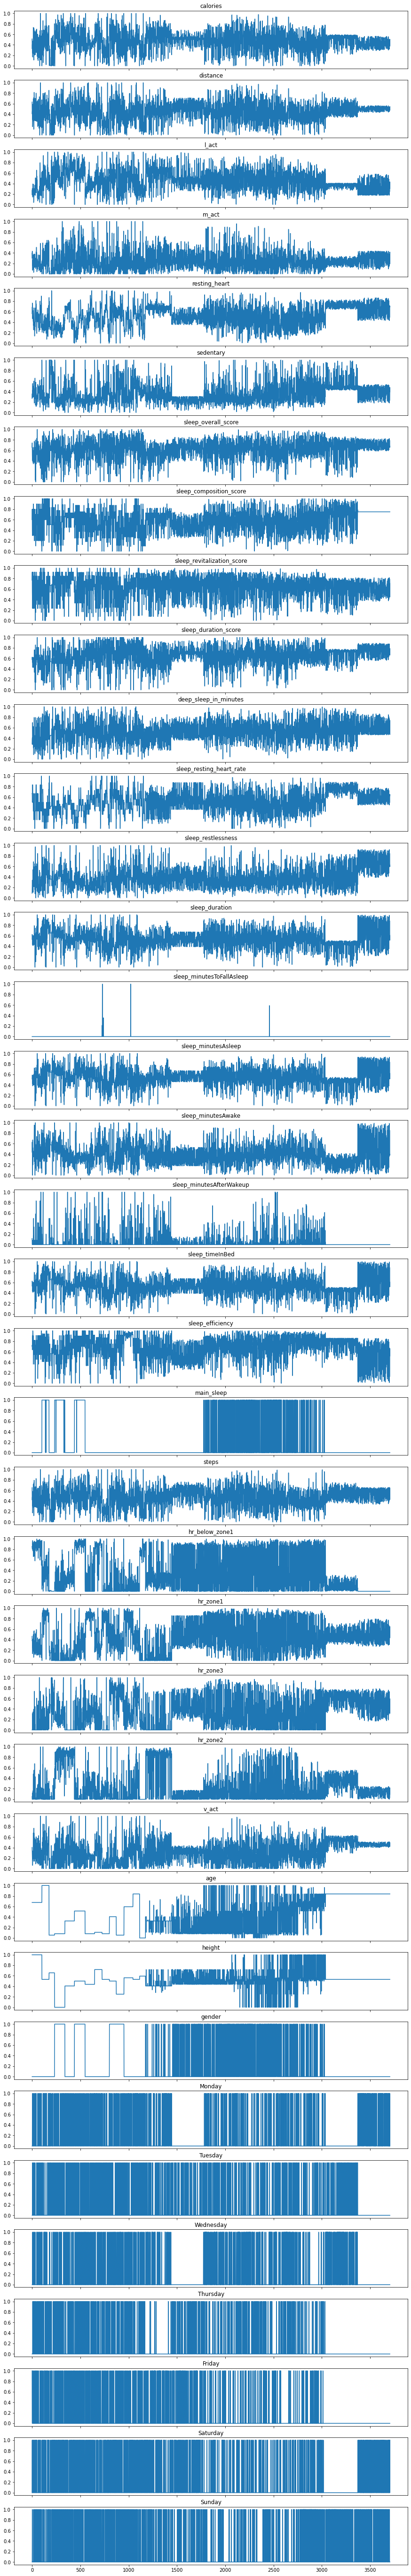

In [7]:
#plotting data

%matplotlib inline

import matplotlib.pyplot as plt

fig, axs = plt.subplots(len(agg_Xtrain.columns), sharex=True, figsize=(15,100))

for i in range(len(agg_Xtrain.columns)):

    axs[i].set_title(agg_Xtrain.columns[i])
    axs[i].plot(agg_Xtrain.iloc[:,i].reset_index(drop=True))


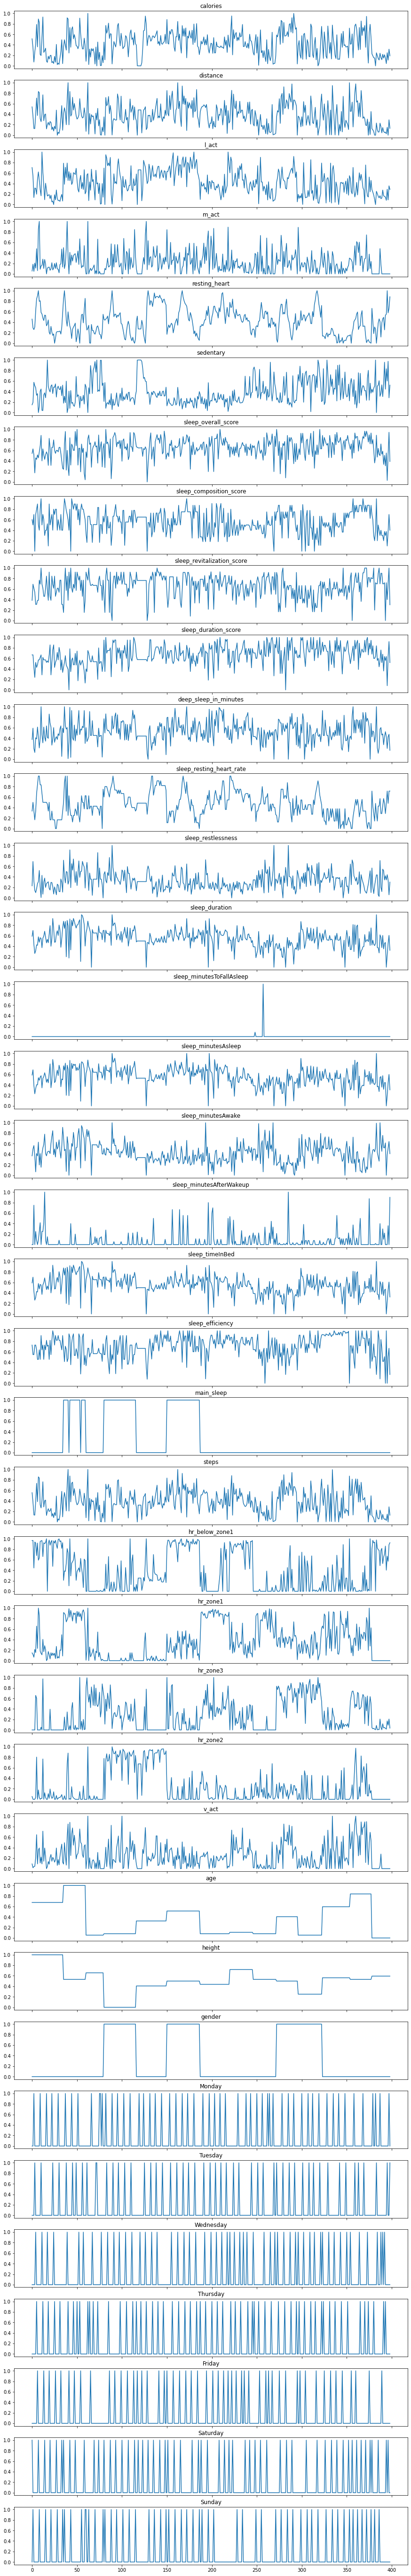

In [8]:

fig, axs = plt.subplots(len(agg_Xtest.columns), sharex=True, figsize=(15,100))

for i in range(len(agg_Xtest.columns)):

    axs[i].set_title(agg_Xtest.columns[i])
    axs[i].plot(agg_Xtest.iloc[:,i].reset_index(drop=True))

In [9]:
knn5_0 = [116,117,119,123,124,125,128,129,130,131,132,133,134,135,136,
137,138,139,140,141,143,144,145,147,148]

calories  distance     l_act     m_act  resting_heart  sedentary  \
2020-02-22  0.515635  0.540113  0.703854  0.054795       0.458628   0.147826   
2020-02-23  0.342675  0.360752  0.539554  0.184932       0.291244   0.193789   
2020-02-24  0.072968  0.127219  0.133874  0.047945       0.259579   0.576398   
2020-02-25  0.263806  0.126279  0.314402  0.205479       0.309013   0.510559   
2020-02-26  0.408621  0.402226  0.308316  0.109589       0.619027   0.473292   
2020-02-27  0.788822  0.707808  0.196755  0.479452       0.842520   0.329193   
2020-02-28  0.361614  0.374647  0.476673  0.061644       0.901702   0.360248   
2020-02-29  0.892883  0.831418  0.620690  0.856164       1.000000   0.000000   
2020-03-01  0.825968  0.810323  0.462475  1.000000       0.796694   0.106832   
2020-03-02  0.216151  0.316647  0.283976  0.089041       0.809494   0.407453   
2020-03-03  0.197984  0.258086  0.166329  0.150685       0.583826   0.448447   
2020-03-04  0.547076  0.400804  1.000000  0.164384       0.557481   0.040994   
2020-03-05  0.930909  0.768878  0.616633  0.280822       0.477595   0.038509   
2020-03-06  0.256769  0.276994  0.361055  0.102740       0.431597   0.336646   
2020-03-07  0.287038  0.389727  0.091278  0.273973       0.534545   0.375155   
2020-03-08  0.336894  0.403752  0.405680  0.184932       0.529106   0.281988   
2020-03-09  0.090498  0.120549  0.279919  0.000000       0.331826   0.491925   
2020-03-11  0.066675  0.199912  0.162272  0.109589       0.365970   1.000000   
2020-03-12  0.184522  0.244116  0.178499  0.123288       0.443109   0.500621   
2020-03-13  0.130233  0.190647  0.188641  0.130137       0.205557   0.432298   
2020-03-14  0.192407  0.259831  0.113590  0.068493       0.170814   0.392547   
2020-03-15  0.202820  0.244028  0.178499  0.095890       0.320526   0.504348   
2020-03-16  0.060838  0.106155  0.050710  0.212329       0.211516   0.527950   
2020-03-17  0.082417  0.155151  0.066937  0.075342       0.148916   0.361491   
2020-03-18  0.044987  0.080316  0.000000  0.109589       0.177632   0.485714   
2020-03-19  0.180833  0.169643  0.186613  0.198630       0.000000   0.480745   
2020-03-20  0.070231  0.118149  0.089249  0.102740       0.091881   0.545342   
2020-03-21  0.409153  0.478110  0.277890  0.212329       0.209502   0.294410   
2020-03-22  0.023668  0.000000  0.113590  0.095890       0.221048   0.463354   
2020-03-23  0.051420  0.055922  0.075051  0.089041       0.219160   0.501863   
2020-03-24  0.028993  0.033816  0.079108  0.020548       0.224767   0.448447   
2020-03-26  0.151200  0.126636  0.060852  0.178082       0.230380   0.436025   
2020-03-27  0.263050  0.322026  0.139959  0.191781       0.174015   0.498137   
2020-03-28  0.496711  0.563288  0.192698  0.472603       0.303393   0.321739   
2020-03-29  0.042695  0.094664  0.066937  0.130137       0.585339   0.521739   
2020-02-22  0.366492  0.409583  0.787356  0.500000       0.854903   0.178427   
2020-02-23  0.496698  0.522050  0.385057  0.102564       1.000000   0.310484   
2020-02-24  0.393992  0.435525  0.709770  0.192308       0.758576   0.187500   
2020-02-25  0.299747  0.199603  0.514368  0.487179       0.447754   0.597782   
2020-02-26  0.914515  0.677446  0.790230  1.000000       0.324347   0.000000   
2020-02-27  0.894083  1.000000  0.456897  0.333333       0.597762   0.084677   
2020-02-28  0.244897  0.197991  0.626437  0.000000       0.440713   0.408266   
2020-02-29  0.728972  0.832458  0.454023  0.410256       0.327541   0.079637   
2020-03-01  0.354724  0.363594  0.600575  0.166667       0.263387   0.419355   
2020-03-02  0.696736  0.397003  0.382184  0.358974       0.089556   0.175403   
2020-03-03  0.743304  0.721380  0.419540  0.243590       0.265743   0.193548   
2020-03-05  0.514926  0.479773  0.606322  0.346154       0.307805   0.137097   
2020-03-06  0.595094  0.604324  0.594828  0.371795       0.337279   0.117944   
2020-03-07  0.516239  0.492064  0.571839  0.384615       0.382568   0.198589   
2020-03-10  

In [18]:
a = []
for i in knn5_0:
    a.append(before_norm.reset_index(drop=True).loc[i])
a = pd.concat(a,axis=1)
a = pd.DataFrame(a.T)

In [19]:
a['age']

116    35.0
117    35.0
119    35.0
123    35.0
124    35.0
125    35.0
128    35.0
129    35.0
130    35.0
131    35.0
132    35.0
133    35.0
134    35.0
135    35.0
136    35.0
137    35.0
138    35.0
139    35.0
140    35.0
141    35.0
143    35.0
144    35.0
145    35.0
147    35.0
148    35.0
Name: age, dtype: float64

In [24]:
a

calories  distance     l_act  m_act  resting_heart  sedentary  \
116  0.393270  0.276004  0.582418  0.096       0.412204   0.413793   
117  0.002189  0.000000  0.000000  0.000       0.515375   0.998136   
119  0.000000  0.481129  0.660444  0.000       0.271257   1.000000   
123  0.313342  0.318951  0.271978  0.176       0.356023   0.850885   
124  0.668366  0.478914  0.840659  0.312       0.178077   0.649581   
125  0.676596  0.497154  0.771978  0.184       0.081236   0.669152   
128  0.384108  0.142291  0.398352  0.080       0.857408   0.356011   
129  0.519004  0.379903  0.445055  0.632       1.000000   0.391426   
130  0.582217  0.369506  0.769231  0.168       0.898254   0.359739   
131  0.550058  0.380850  0.675824  0.312       0.726443   0.154706   
132  0.469523  0.251871  0.456044  0.328       0.810320   0.286114   
133  0.496364  0.268453  0.620879  0.128       0.788687   0.390494   
134  0.568315  0.492466  0.741758  0.160       0.699307   0.336440   
135  0.567904  0.283681  0.541209  0.520       0.815908   0.405405   
136  0.533909  0.365685  0.538462  0.360       0.957003   0.390494   
137  0.563152  0.477583  0.582418  0.312       0.857401   0.353215   
138  0.613056  0.585802  0.519231  0.352       0.886300   0.309413   
139  0.667997  0.701206  0.653846  0.536       0.890967   0.287046   
140  0.419149  0.328315  0.725275  0.048       0.882692   0.370923   
141  0.463501  0.364853  0.728022  0.112       0.864821   0.323392   
143  0.577365  0.596808  0.601648  0.288       0.861784   0.319664   
144  0.422901  0.339434  0.656593  0.088       0.843961   0.321528   
145  0.412327  0.262434  0.560440  0.176       0.770194   0.400746   
147  0.458457  0.319295  0.642857  0.184       0.839050   0.312209   
148  0.601725  0.475833  0.631868  0.320       0.767089   0.322460   

     sleep_overall_score  sleep_composition_score  sleep_revitalization_score  \
116             0.666667                 0.545455                    0.923077   
117             0.660000                 0.650216                    0.763370   
119             0.646667                 0.650216                    0.763370   
123             0.486667                 0.650216                    0.763370   
124             0.633333                 0.650216                    0.763370   
125             0.613333                 0.650216                    0.763370   
128             0.000000                 0.000000                    0.000000   
129             0.333333                 0.545455                    0.153846   
130             0.566667                 0.545455                    0.692308   
131             0.800000                 0.454545                    0.769231   
132             0.933333                 0.727273                    0.846154   
133             0.433333                 0.272727                    0.769231   
134             0.566667                 0.363636                    0.923077   
135             0.666667                 0.727273                    0.846154   
136             0.300000                 0.363636                    0.153846   
137             0.766667                 0.545455                    0.923077   
138             0.833333                 0.727273                    0.846154   
139             0.900000                 0.727273                    1.000000   
140             0.800000                 0.545455                    0.923077   
141             0.833333                 0.727273                    0.923077   
143             0.900000                 0.818182                    0.923077   
144             0.800000                 0.636364                    0.846154   
145             0.533333                 0.454545                    0.769231   
147             0.966667                 0.818182                    0.846154   
148             0.833333                 0.727273                    0.769231   

     sleep_duration_score  deep_sleep_in_minutes  sleep_resting_heart_rate  \

In [27]:
pd.concat([P05_ytrain,P05_Xtrain],axis=1)

readiness  calories  distance     l_act     m_act  resting_heart  \
2019-11-01        6.0  0.513234  0.632468  0.269777  0.397260       0.682528   
2019-11-02        8.0  0.322988  0.403389  0.182556  0.294521       0.557946   
2019-11-03        8.0  0.409069  0.455662  0.304260  0.431507       0.607300   
2019-11-04        8.0  0.250904  0.300456  0.239351  0.157534       0.765151   
2019-11-05        5.0  0.427432  0.590145  0.306288  0.150685       0.467740   
2019-11-06        7.0  0.186506  0.160945  0.190669  0.068493       0.749505   
2019-11-07        7.0  0.167087  0.192367  0.141988  0.075342       0.588165   
2019-11-08        8.0  0.365663  0.390514  0.202840  0.260274       0.624697   
2019-11-09        7.0  0.474632  0.564631  0.391481  0.212329       0.581017   
2019-11-11        4.0  0.355193  0.417700  0.219067  0.089041       0.504118   
2019-11-12        7.0  0.264030  0.272535  0.221095  0.109589       0.446870   
2019-11-13        7.0  0.234718  0.310055  0.172414  0.164384       0.414145   
2019-11-14        5.0  0.732137  0.695014  0.194726  0.363014       0.420516   
2019-11-15        6.0  0.572028  0.668155  0.310345  0.308219       0.411494   
2019-11-16        6.0  0.513742  0.509329  0.385396  0.321918       0.341754   
2019-11-17        8.0  0.301520  0.344771  0.275862  0.191781       0.355200   
2019-11-18        5.0  0.267471  0.193557  0.038540  0.027397       0.253656   
2019-11-19        7.0  0.110382  0.112980  0.066937  0.041096       0.578813   
2019-11-20        7.0  0.261930  0.255842  0.178499  0.253425       0.571546   
2019-11-21        4.0  0.722840  0.718259  0.172414  0.376712       0.561696   
2019-11-22        8.0  0.258389  0.295790  0.152130  0.294521       0.674172   
2019-11-23        6.0  0.690138  0.815577  0.231237  0.301370       0.609504   
2019-11-24        7.0  0.481617  0.570942  0.306288  0.184932       0.572268   
2019-11-25        7.0  0.304981  0.364187  0.281947  0.130137       0.421395   
2019-11-26        5.0  0.518139  0.620933  0.182556  0.301370       0.334522   
2019-11-27        7.0  0.204849  0.280619  0.215010  0.123288       0.356714   
2019-11-28        4.0  0.656545  0.617073  0.257606  0.246575       0.136201   
2019-11-29        6.0  0.475064  0.543580  0.290061  0.376712       0.402652   
2019-11-30        7.0  0.273780  0.291133  0.312373  0.212329       0.386488   
2019-12-01        8.0  0.375192  0.430401  0.371197  0.226027       0.243662   
2019-12-02        7.0  0.252264  0.361175  0.227181  0.130137       0.233909   
2019-12-03        5.0  0.614330  0.703980  0.221095  0.157534       0.257630   
2019-12-04        6.0  0.299128  0.337886  0.215010  0.205479       0.401061   
2019-12-05        3.0  0.652452  0.648298  0.304260  0.301370       0.316006   
2019-12-06        6.0  0.211334  0.272952  0.174442  0.171233       0.671910   
2019-12-07        6.0  0.454701  0.490594  0.509128  0.164384       0.542291   
2019-12-08        4.0  0.500600  0.532576  0.377282  0.226027       0.403709   
2019-12-09        4.0  0.281421  0.309356  0.361055  0.184932       0.583385   
2019-12-12        6.0  0.275584  0.282499  0.328600  0.102740       0.669251   
2019-12-13        6.0  0.453088  0.533412  0.383367  0.157534       0.800821   
2019-12-14        7.0  0.419607  0.507898  0.387424  0.246575       0.811862   
2019-12-15        7.0  0.681721  0.801335  0.496957  0.417808       0.753503   
2019-12-16        7.0  0.252688  0.271324  0.223124  0.246575       0.719900   
2019-12-20        7.0  0.374008  0.401092  0.316430  0.130137       0.744363   
2019-12-21        7.0  0.485090  0.628010  0.233266  0.246575       0.711372   
2019-12-22        7.0  0.636166  0.645720  0.444219  0.506849       0.466327   
2019-12-24        8.0  0.494419  0.413035  0.655172  0.191781       0.437341   
2019-12-25        7.0  0.291731  0.339173  0.292089  0.363014       0.326978   
2019-12-26        4.0  0.700112  0.629514  0.354970  0.404110       0.277498   
2019-12-27  

In [29]:
pd.concat([P05_ytest, P05_Xtest], axis=1)

readiness  calories  distance     l_act     m_act  resting_heart  \
2020-02-22        6.0  0.515635  0.540113  0.703854  0.054795       0.458628   
2020-02-23        6.0  0.342675  0.360752  0.539554  0.184932       0.291244   
2020-02-24        7.0  0.072968  0.127219  0.133874  0.047945       0.259579   
2020-02-25        8.0  0.263806  0.126279  0.314402  0.205479       0.309013   
2020-02-26        6.0  0.408621  0.402226  0.308316  0.109589       0.619027   
2020-02-27        3.0  0.788822  0.707808  0.196755  0.479452       0.842520   
2020-02-28        5.0  0.361614  0.374647  0.476673  0.061644       0.901702   
2020-02-29        6.0  0.892883  0.831418  0.620690  0.856164       1.000000   
2020-03-01        3.0  0.825968  0.810323  0.462475  1.000000       0.796694   
2020-03-02        6.0  0.216151  0.316647  0.283976  0.089041       0.809494   
2020-03-03        7.0  0.197984  0.258086  0.166329  0.150685       0.583826   
2020-03-04        8.0  0.547076  0.400804  1.000000  0.164384       0.557481   
2020-03-05        2.0  0.930909  0.768878  0.616633  0.280822       0.477595   
2020-03-06        6.0  0.256769  0.276994  0.361055  0.102740       0.431597   
2020-03-07        7.0  0.287038  0.389727  0.091278  0.273973       0.534545   
2020-03-08        7.0  0.336894  0.403752  0.405680  0.184932       0.529106   
2020-03-09        8.0  0.090498  0.120549  0.279919  0.000000       0.331826   
2020-03-11        7.0  0.066675  0.199912  0.162272  0.109589       0.365970   
2020-03-12        8.0  0.184522  0.244116  0.178499  0.123288       0.443109   
2020-03-13        8.0  0.130233  0.190647  0.188641  0.130137       0.205557   
2020-03-14        4.0  0.192407  0.259831  0.113590  0.068493       0.170814   
2020-03-15        6.0  0.202820  0.244028  0.178499  0.095890       0.320526   
2020-03-16        7.0  0.060838  0.106155  0.050710  0.212329       0.211516   
2020-03-17        7.0  0.082417  0.155151  0.066937  0.075342       0.148916   
2020-03-18        7.0  0.044987  0.080316  0.000000  0.109589       0.177632   
2020-03-19        7.0  0.180833  0.169643  0.186613  0.198630       0.000000   
2020-03-20        7.0  0.070231  0.118149  0.089249  0.102740       0.091881   
2020-03-21        8.0  0.409153  0.478110  0.277890  0.212329       0.209502   
2020-03-22        8.0  0.023668  0.000000  0.113590  0.095890       0.221048   
2020-03-23        8.0  0.051420  0.055922  0.075051  0.089041       0.219160   
2020-03-24        8.0  0.028993  0.033816  0.079108  0.020548       0.224767   
2020-03-26        6.0  0.151200  0.126636  0.060852  0.178082       0.230380   
2020-03-27        8.0  0.263050  0.322026  0.139959  0.191781       0.174015   
2020-03-28        8.0  0.496711  0.563288  0.192698  0.472603       0.303393   
2020-03-29        8.0  0.042695  0.094664  0.066937  0.130137       0.585339   
2020-02-22        6.0  0.366492  0.409583  0.787356  0.500000       0.854903   
2020-02-23        5.0  0.496698  0.522050  0.385057  0.102564       1.000000   
2020-02-24        5.0  0.393992  0.435525  0.709770  0.192308       0.758576   
2020-02-25        6.0  0.299747  0.199603  0.514368  0.487179       0.447754   
2020-02-26        7.0  0.914515  0.677446  0.790230  1.000000       0.324347   
2020-02-27        5.0  0.894083  1.000000  0.456897  0.333333       0.597762   
2020-02-28        6.0  0.244897  0.197991  0.626437  0.000000       0.440713   
2020-02-29        6.0  0.728972  0.832458  0.454023  0.410256       0.327541   
2020-03-01        6.0  0.354724  0.363594  0.600575  0.166667       0.263387   
2020-03-02        6.0  0.696736  0.397003  0.382184  0.358974       0.089556   
2020-03-03        5.0  0.743304  0.721380  0.419540  0.243590       0.265743   
2020-03-05        5.0  0.514926  0.479773  0.606322  0.346154       0.307805   
2020-03-06        5.0  0.595094  0.604324  0.594828  0.371795       0.337279   
2020-03-07        4.0  0.516239  0.492064  0.571839  0.384615       0.382568   
2020-03-10  